<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/97_72_(LSTM%2BCNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사전작업

In [ ]:
#필요한 모듈 불러오기
import pandas as pd  

from keras.layers import Dense,Input,Bidirectional,Conv1D,LSTM
from keras.layers import Embedding,GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, Flatten
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split 

import spacy

In [ ]:
#데이터
train_file = pd.read_csv('/content/drive/MyDrive/train.csv')
test_file = pd.read_csv('/content/drive/MyDrive/test.csv')

X_train = train_file["comment_text"].str.lower()
X_test = test_file["comment_text"].str.lower()

y_train = train_file[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [ ]:
print("X train shape : ", X_train.shape)
print("X test shape : ", X_test.shape)
print("y train shape : ", y_train.shape)

X train shape :  (159571,)
X test shape :  (153164,)
y train shape :  (159571, 6)


# 토큰화 작업하기

In [ ]:
max_features=150000
maxlen=200
embed_size=300

tok=text.Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(list(X_train)+list(X_test))
X_train=tok.texts_to_sequences(X_train)
X_test=tok.texts_to_sequences(X_test)
x_train=sequence.pad_sequences(X_train,maxlen=maxlen)
x_test=sequence.pad_sequences(X_test,maxlen=maxlen)

# 모델 구성하기

In [ ]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, embed_size)(input)
layer = SpatialDropout1D(0.1)(layer)
layer = Bidirectional(LSTM(200, return_sequences=True,dropout=0.25,recurrent_dropout=0.25,implementation=1))(layer)
layer = Conv1D(128, kernel_size = 3)(layer)   
avg_pool = GlobalAveragePooling1D()(layer)
max_pool = GlobalMaxPooling1D()(layer)
layer = concatenate([avg_pool, max_pool])
layer= Dense(6, activation="sigmoid")(layer)
model = Model(inputs = input, outputs = layer)  
model.summary()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     45000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 400)     801600      spatial_dropout1d[0][0]          
______________________________________________________________________________________________

In [ ]:
hist = model.fit(x_train,y_train,batch_size=32, epochs=1, validation_split = 0.2,verbose=1)

3990/3990 [==============================] - 9112s 2s/step - loss: 0.0513 - accuracy: 0.9508 - val_loss: 0.0458 - val_accuracy: 0.9832


In [ ]:
model.save('/content/drive/MyDrive/toxic1_model2.h5')

In [ ]:
y_pred = model.predict(x_test,batch_size=1024,verbose=1)

150/150 [==============================] - 37s 242ms/step


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('/content/drive/MyDrive/submission2.csv', index=False)

In [ ]:
import matplotlib.pyplot as plt
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

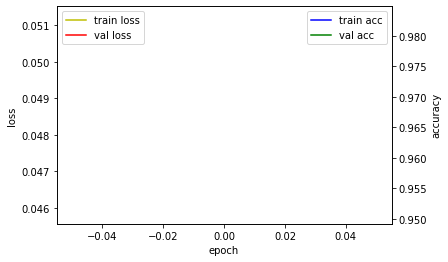

In [ ]:
acc_loss_plot(hist)